In [1]:
import pandas as pd
from gensim.utils import simple_preprocess
import torch
from transformers import GPT2Tokenizer, GPT2Model
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import gensim
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import torchtext.data as data
import random
from transformers import BertModel, BertTokenizer
from sentence_transformers import SentenceTransformer
from nltk.tokenize import word_tokenize


functions
-------------

In [2]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

def train(model, iterator, optimizer, criterion, max_norm = 1.0):
    epoch_loss = 0
    epoch_acc = 0

    model.train()  

    for inputs, labels in iterator:
        optimizer.zero_grad() 
        predictions = model(inputs).squeeze(1) 

        loss = criterion(predictions, labels) 
        acc = binary_accuracy(predictions, labels)
        
        
        loss.backward() 
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)
        optimizer.step() 

        epoch_loss += loss.item() 
        epoch_acc += acc.item() 

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()  

    with torch.no_grad(): 
        for inputs, labels in iterator:
            predictions = model(inputs).squeeze(1) 
            loss = criterion(predictions, labels) 
            acc = binary_accuracy(predictions, labels)  

            epoch_loss += loss.item() 
            epoch_acc += acc.item() 

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def count_metrics(model, iterator):
    model.eval()  
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in iterator:
            preds = model(inputs).squeeze(1)
            all_preds.extend(preds.cpu())
            all_labels.extend(labels.cpu())

    all_preds = torch.tensor(all_preds)
    y_pred_binary = torch.round(torch.sigmoid(all_preds)).numpy()
    y_true = torch.tensor(all_labels).numpy()

    accuracy = accuracy_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)

    print(f"Accuracy: {accuracy:.4f}\nF1 Score: {f1:.4f}")
    
      
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(15, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', marker='o', color='blue')
    plt.plot(val_losses, label='Validation Loss', marker='x', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy', marker='o', color='blue')
    plt.plot(val_accuracies, label='Validation Accuracy', marker='x', color='red')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

preprocessing
----------

In [3]:
df = pd.read_csv('email_text.csv')[:1000]

In [4]:
top100acro = torch.load("top100acronyms.pth")
top100abbs = torch.load("top100abbs.pth")
filterdict = top100acro | top100abbs
filterdict = {key.lower(): value.lower() for key, value in filterdict.items()}

In [5]:
stop_words = set(stopwords.words('english')) 
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    
    # чистим аббревиатуры
    for abb, meaning in filterdict.items():
        text = text.replace(abb, meaning)
        
    # Преобразование сокращений
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'m", " am", text)
    
    # токенизация
    text = gensim.utils.simple_preprocess(text)
    # удаляем стоп-слова
    tokens = [word for word in text if word not in stop_words]
    # лемматизируем
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = ' '.join(tokens)
    
    return tokens

In [6]:
df['text'] = df['text'].apply(lambda x: preprocess_text(x))

In [7]:
empty_indices = df.index[df['text'].str.strip().eq('')].tolist()
df = df.drop(index=empty_indices)

In [19]:
N_EPOCHS = 1000
OUTPUT_SIZE = 1
DROPOUT= 0.3
DEVICE = torch.device('cpu')
BATCH_SIZE = 64

Embeddings from gpt2 (done in Collab with GPU, so here we only import it)
-----------

In [9]:
'''
tokenizer_GPT = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer_GPT.pad_token = tokenizer_GPT.eos_token
model_GPT = GPT2Model.from_pretrained('gpt2')
model_GPT.to(DEVICE)

# Tokenize и pad sequences
encoded_captions = tokenizer_GPT(
    df['text'].tolist(),
    return_tensors='pt',
    padding=True,
    truncation=True)

encoded_captions = {key: value.to(DEVICE) for key, value in encoded_captions.items()}

input_ids = encoded_captions['input_ids']

b_size = 4

# Инициализируем список для хранения embeddings
all_sentence_embeddings = []

# Разделим данные на батчи и передадим их в модель
for i in range(0, len(encoded_captions['input_ids']), b_size):
    batch_input_ids = encoded_captions['input_ids'][i:i+b_size].to(DEVICE)
    batch_attention_mask = encoded_captions['attention_mask'][i:i+b_size].to(DEVICE)

    # Передаем батчи в модель
    with torch.no_grad():
        batch_outputs = model_GPT(batch_input_ids)

    # Извлекаем embeddings для каждого батча
    word_embeddings = batch_outputs.last_hidden_state

    # Mask для игнорирования padding tokens
    masked_word_embeddings = word_embeddings * batch_attention_mask.unsqueeze(-1).float()

    # Объединение сумм с учётом токенов без non-padding
    sentence_embeddings = masked_word_embeddings.sum(dim=1)

    # Нормализация по количеству токенов без non-padding
    sentence_embeddings /= batch_attention_mask.sum(dim=1, keepdim=True).float()

    # Добавляем embeddings батча в список
    all_sentence_embeddings.append(sentence_embeddings)

# Собираем все embeddings батчей в один список
all_sentence_embeddings = torch.cat(all_sentence_embeddings, dim=0)'''

"\ntokenizer_GPT = GPT2Tokenizer.from_pretrained('gpt2')\ntokenizer_GPT.pad_token = tokenizer_GPT.eos_token\nmodel_GPT = GPT2Model.from_pretrained('gpt2')\nmodel_GPT.to(DEVICE)\n\n# Tokenize и pad sequences\nencoded_captions = tokenizer_GPT(\n    df['text'].tolist(),\n    return_tensors='pt',\n    padding=True,\n    truncation=True)\n\nencoded_captions = {key: value.to(DEVICE) for key, value in encoded_captions.items()}\n\ninput_ids = encoded_captions['input_ids']\n\nb_size = 4\n\n# Инициализируем список для хранения embeddings\nall_sentence_embeddings = []\n\n# Разделим данные на батчи и передадим их в модель\nfor i in range(0, len(encoded_captions['input_ids']), b_size):\n    batch_input_ids = encoded_captions['input_ids'][i:i+b_size].to(DEVICE)\n    batch_attention_mask = encoded_captions['attention_mask'][i:i+b_size].to(DEVICE)\n\n    # Передаем батчи в модель\n    with torch.no_grad():\n        batch_outputs = model_GPT(batch_input_ids)\n\n    # Извлекаем embeddings для каждого ба

Check the empeddings and modeling
----------------

In [10]:
all_sentence_embeddings = torch.load('all_sentence_embeddings.pth',map_location=torch.device('cpu'))

In [11]:
all_sentence_embeddings.shape

torch.Size([998, 768])

In [12]:
torch.isnan(all_sentence_embeddings).any()

tensor(False)

In [13]:
y=df['label']
Xtrain, Xtest, ytrain, ytest = train_test_split(all_sentence_embeddings, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
# Преобразование данных в тензоры PyTorch
X_train_tensor = torch.tensor(Xtrain, dtype=torch.float32)
X_test_tensor = torch.tensor(Xtest, dtype=torch.float32)
y_train_tensor = torch.tensor(ytrain.values, dtype=torch.float32)
y_test_tensor = torch.tensor(ytest.values, dtype=torch.float32)

# Создание DataLoader для обучающего и тестового наборов данных
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

C:\Users\ESC\AppData\Local\Temp\ipykernel_14704\2105403109.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(Xtrain, dtype=torch.float32)
C:\Users\ESC\AppData\Local\Temp\ipykernel_14704\2105403109.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(Xtest, dtype=torch.float32)


In [23]:
class Email_classifier(nn.Module):
    def __init__(self, output_size, dropout):
        super().__init__()
        self.model = nn.Sequential(
            nn.LazyLinear(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.LazyLinear(output_size),
        )

    def forward(self, x):
        return self.model(x)

model_GPT = Email_classifier(OUTPUT_SIZE, DROPOUT)
optimizer = optim.Adam(model_GPT.parameters(), lr=0.0001, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()

model_GPT = model_GPT.to(DEVICE)
criterion = criterion.to(DEVICE)

train_losses_GPT , val_losses_GPT, train_accuracies_GPT, val_accuracies_GPT = [],[],[],[]

c:\Users\ESC\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [24]:
ES = True
best_val_loss = 10 #for early stopping
early_stopping_rate = 10 #for early stopping
early_stopping_rate_counter = 0 #for early stopping


for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model_GPT, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model_GPT, test_loader, criterion)

    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.3f}, Val Acc: {val_acc*100:.2f}%')

    train_losses_GPT.append(train_loss)
    train_accuracies_GPT.append(train_acc)
    val_losses_GPT.append(val_loss)
    val_accuracies_GPT.append(val_acc)

#Early stopping
    if ES:
        if  val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_rate_counter = 0
        else:
            early_stopping_rate_counter += 1

        if early_stopping_rate_counter >= early_stopping_rate:
            print("Stopping early")
            break



Epoch: 01, Train Loss: 0.703, Train Acc: 59.49%, Val Loss: 0.629, Val Acc: 67.58%
Epoch: 02, Train Loss: 0.684, Train Acc: 65.19%, Val Loss: 0.618, Val Acc: 67.58%
Epoch: 03, Train Loss: 0.667, Train Acc: 63.17%, Val Loss: 0.614, Val Acc: 67.58%
Epoch: 04, Train Loss: 0.654, Train Acc: 63.80%, Val Loss: 0.605, Val Acc: 67.58%
Epoch: 05, Train Loss: 0.630, Train Acc: 65.00%, Val Loss: 0.596, Val Acc: 67.97%
Epoch: 06, Train Loss: 0.618, Train Acc: 66.19%, Val Loss: 0.585, Val Acc: 67.97%
Epoch: 07, Train Loss: 0.613, Train Acc: 67.57%, Val Loss: 0.571, Val Acc: 67.97%
Epoch: 08, Train Loss: 0.604, Train Acc: 67.08%, Val Loss: 0.558, Val Acc: 68.36%
Epoch: 09, Train Loss: 0.594, Train Acc: 68.57%, Val Loss: 0.544, Val Acc: 68.36%
Epoch: 10, Train Loss: 0.568, Train Acc: 70.59%, Val Loss: 0.528, Val Acc: 75.39%
Epoch: 11, Train Loss: 0.569, Train Acc: 70.92%, Val Loss: 0.509, Val Acc: 73.05%
Epoch: 12, Train Loss: 0.548, Train Acc: 71.70%, Val Loss: 0.492, Val Acc: 80.47%
Epoch: 13, Train

Accuracy: 0.9350
F1 Score: 0.9037


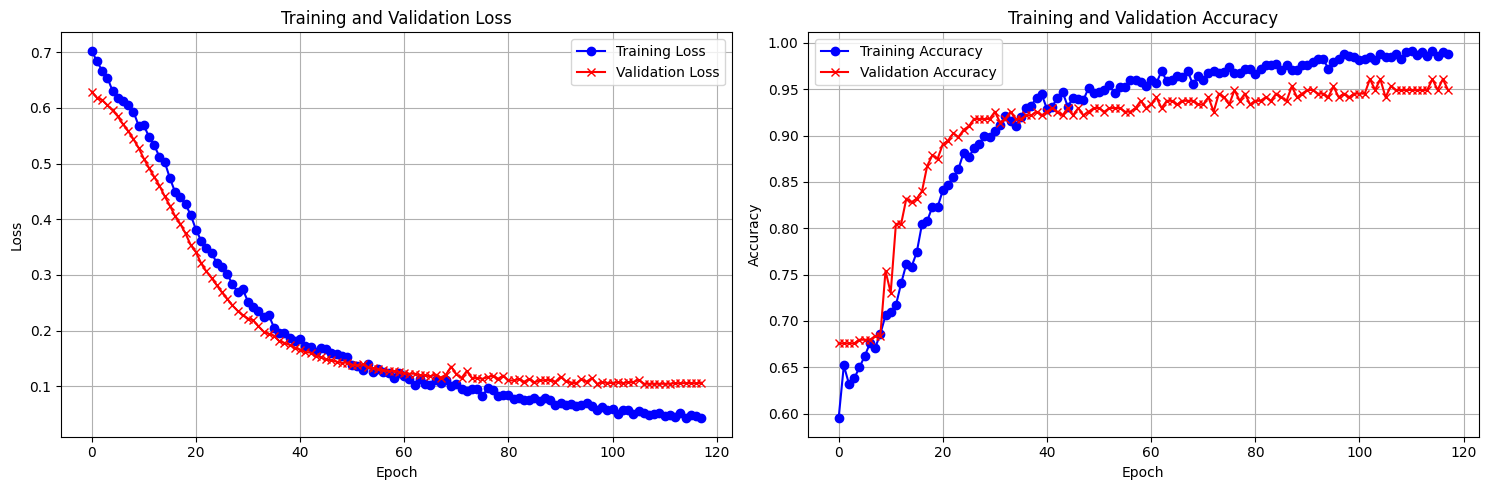

In [25]:
count_metrics(model_GPT, test_loader)
plot_metrics(train_losses_GPT , val_losses_GPT, train_accuracies_GPT, val_accuracies_GPT)